# Marked processes #

We shall be interested in spatial processes which occur in time.

- For example, we might wish to model a self-exciting process where events occur at a location in (2 or 3 dimensional) space, and the "offspring" events show a clustering behaviour close to the parent event.

The standard way of treating such a process is via "marks".  We start with a temporal process as already discussed, and to each event we also associate a "mark" from a "mark space".

- Our mark space will be $\mathbb R^2$, or a subset thereof, i.e. a 2 dimensional point in space.
- Marks can also be discrete, for example to classify events into a number of different types.

We shall consider a restricted setup.  Marks may occur in a "mark space" $M$ (probably $M\subseteq \mathbb R^2$.

- Immigrants will have independently chosen marks, say with density $\gamma(\kappa,t)$.
- The immigrant intensity may vary with time, $\mu(t)$.
- Offspring intensity is $\alpha(\kappa) \beta(t,\kappa)$ where $\alpha$ is the "total intensity" depending on the mark, and $\beta$ is taken to be a normalised intensity, depending on time and the mark.
- The offspring marks are independent and only depend upon the time and mark of the parent.

Thus the total intensity function is
$$ \lambda^*(t) = \mu(t) + \sum_{t_i < t} \alpha(\kappa_i) \beta(t-t_i,\kappa_i). $$

An example of an ETAS (epidemic type aftershock model) has mark space consisting triples $\kappa=(m,x,y)$ where $m>0$ is the "magnitude" of the event, and $(x,y)$ are coordinates in a window $W$.

- $\mu(t) = \mu_1$ for $t\geq 0$.  So background intensity is constant.
- $\alpha(\kappa) = \alpha_1 e^{m \alpha_2}$.  So the total intensity is exponential in the magnitude.
- $\beta(t,\kappa) = \beta(t)$ is some decaying function in $t$.  For example, a power law
$$ \beta(t) = \frac{\beta_2}{\beta_1} \Big( 1+\frac{t}{\beta_1} \Big)^{-\beta_2-1} $$
where we scale by $\beta_1$, and decay at rate $\beta_2$, and normalise.  Notice that this example is independant of the mark.
- For immigrants we have mark density $\gamma_1 e^{-\gamma_1 m} |W|^{-1}$ for $(x,y)\in W$.  So the coordinates of events are uniform in $W$, and the magnitude follows an exponential distribution.
- For offspring, we have a more complicated mark density:
$$ \gamma(\kappa | t, (t_p,\kappa_p)) = \gamma_1 e^{-\gamma_1 m} \frac{1}{2\pi\gamma_2^2}
\exp\Big( - \frac{\| (x,y) - (x_p,y_p) \|^2}{2\gamma_2^2} \Big) $$
where the parent event occurred at time $t_p$ with mark $\kappa_p$.  Thus the magnitude continues to follow an exponential distribution, but the location of the "aftershock" follows a Gaussian distribution centred on the location of the parent event.

Here we have followed [Rasmussen, "Bayesian Inference for Hawkes Processes"](https://doi.org/10.1007/s11009-011-9272-5).

This approach via "marks" may seem complicated, but it allows use to easily adapt the simulation procedure from the unmarked case, by simply adding in the marks.

Let us consider a one dimensional mark space, which is easier to visualise.

- $\mu(t) = \mu$
- $\alpha(\kappa)=\alpha$
- $\beta(t,\kappa) = (1+t)^{-2}$
- Immigrants will have mark uniformly chosen in $[0,1]$
- Offspring have mark density following a Gaussian centred on the parent location, say with variance $\sigma^2$.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import utils

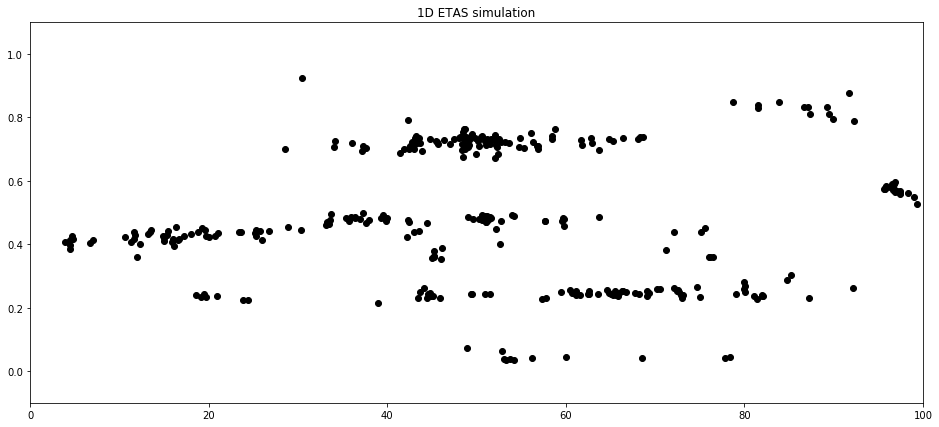

In [37]:
from collections import namedtuple
Event = namedtuple("Event", ["t", "loc"])

mu = 0.1
alpha = 1
sigma = 0.01

def simulate_sub_process(parent : Event):
    points = []
    t = 0
    while True:
        t += np.random.exponential()
        if t >= alpha:
            return points
        loc = np.random.normal(loc=parent.loc, scale=sigma)
        if loc >= 0 and loc <= 1:
            points.append(Event(parent.t + t / (alpha - t), loc))
    
def simulate(window_size=100):
    points = utils.sample_poisson_process(window_size, 1/mu)
    points = [Event(t, np.random.uniform()) for t in points]
    to_process = list(points)
    while len(to_process) > 0:
        next_point = to_process.pop()
        for event in simulate_sub_process(next_point):
            if event.t < window_size:
                points.append(event)
                to_process.append(event)
    points.sort(key = lambda e : e.t)
    return points

points = simulate()
width, _ = utils.slim_aspect()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width,7))
ax.set(xlim=[0,100], ylim=[-0.1,1.1], title="1D ETAS simulation")
_ = ax.scatter(x=[e.t for e in points], y=[e.loc for e in points], color="black")

In this example, we have set the background rate to be low, and the mark distribution of offspring to be tightly bound to the location of the parent.  This allows us to visualise how an immigrant sets off a chain of "aftershocks" which spread out slowly in space.

# Some calculations #

The offspring have intensity $\alpha \beta(t) = \alpha (1+t)^{-2}$ and so the compensator is
$$ \Lambda^*(t) = \int_0^t \alpha(1+s)^{-2} \ ds = \alpha \big(1 - (1+t)^{-1} \big) $$
Thus solving $\Lambda^*(t) = s$ gives
$$ t = \frac{s}{\alpha - s} $$